In [1]:
import sys

sys.path.append("c:\\Users\\robin\\Documents\\HyperBrain")
sys.path.append("c:\\Users\\robin\\Documents\\HyperBrain\\source")

import torch
from source.loftr.backbone import ResNetFPN_8_2, ResNetFPN_16_4
from source.datasets.brain_dataset import BrainDataset
from torchvision.transforms import v2

In [2]:
block_dimensions_8_2 = [96, 128, 192]
block_dimensions_16_4 = [64, 96, 128, 192]

backbone_8_2 = ResNetFPN_8_2(block_dimensions=block_dimensions_8_2, verbose=True)
backbone_16_4 = ResNetFPN_16_4(block_dimensions=block_dimensions_16_4, verbose=True)

In [3]:
x = torch.rand(1, 1, 480, 480)
coarse_features_8_2, fine_features_8_2 = backbone_8_2(x)

x (Input Tensor): torch.Size([1, 1, 480, 480])
x0 (Initial Convolution Output): torch.Size([1, 96, 240, 240])
x1 (Layer 1 Output): torch.Size([1, 96, 240, 240])
x2 (Layer 2 Output): torch.Size([1, 128, 120, 120])
x3 (Layer 3 Output): torch.Size([1, 192, 60, 60])
x3_out (Layer 3 OutConv Output): torch.Size([1, 192, 60, 60])
x3_out_2x (Upsampled x3_out): torch.Size([1, 192, 120, 120])
x2_out (Layer 2 OutConv Output): torch.Size([1, 128, 120, 120])
x2_out_2x (Upsampled x2_out): torch.Size([1, 128, 120, 120])
x1_out (Layer 1 OutConv Output): torch.Size([1, 96, 240, 240])

Tensor Dimension Relationships:
x0: Output of the initial convolution, batch normalization, and ReLU applied to the input.
x1: Output of layer1, representing features at 1/2 of the input resolution.
x2: Output of layer2, downsampled to 1/4 of the input resolution.
x3: Output of layer3, further downsampled to 1/8 of the input resolution.
x3_out: Coarse features at 1/8 resolution, output of layer3_outconv.
x3_out_2x: Upsamp

In [4]:
coarse_features_16_4, fine_features_16_4 = backbone_16_4(x)

x (Input Tensor): torch.Size([1, 1, 480, 480])
x0 (Initial Convolution Output): torch.Size([1, 64, 240, 240])
x1 (Layer 1 Output): torch.Size([1, 64, 240, 240])
x2 (Layer 2 Output): torch.Size([1, 96, 120, 120])
x3 (Layer 3 Output): torch.Size([1, 128, 60, 60])
x4 (Layer 4 Output): torch.Size([1, 192, 30, 30])
x4_out (Layer 4 OutConv Output): torch.Size([1, 192, 30, 30])
x4_out_2x (Upsampled x4_out): torch.Size([1, 192, 60, 60])
x3_out (Layer 3 OutConv Output): torch.Size([1, 128, 60, 60])
x3_out_2x (Upsampled x3_out): torch.Size([1, 128, 120, 120])
x2_out (Layer 2 OutConv Output): torch.Size([1, 96, 120, 120])

Tensor Dimension Relationships:
x0 is the result of the initial convolution applied to the input.
x1 to x4 are progressively downsampled features, reducing spatial dimensions while increasing channels.
x4_out (coarse features) is the processed output of x4, which is then upsampled to x4_out_2x.
x3_out combines features from x3 and x4_out_2x.
x3_out_2x is an upsampled version of

In [16]:
coarse_features_8_2.shape, fine_features_8_2.shape, coarse_features_16_4.shape, fine_features_16_4.shape

(torch.Size([1, 192, 80, 80]),
 torch.Size([1, 96, 320, 320]),
 torch.Size([1, 192, 40, 40]),
 torch.Size([1, 96, 160, 160]))

In [5]:
crop_size = 480
transformation_threshold = 0.3
patch_size = 8
max_translation_shift = 50
fine_feature_size = 320
images_directory = "data/cyto_downscaled_3344_3904/"
use_train_data = True

dataset_train = BrainDataset(
    images_directory=images_directory,
    train=use_train_data,
    affine_transformation_range=transformation_threshold,
    crop_size=crop_size,
    patch_size=patch_size,
    max_translation_shift=max_translation_shift,
    fine_height_width=fine_feature_size,
    transform=v2.Compose([v2.Normalize(mean=[0.594], std=[0.204])]),
)

In [6]:
image_1_crop, image_2_crop, match_matrix, relative_coordinates, crop_coordinate_mapping = dataset_train[2]

B20_0431_Slice15_transformed.tif B20_0432_Slice15_transformed.tif


In [7]:
image_1_crop.shape, image_2_crop.shape, match_matrix.shape, relative_coordinates.shape, crop_coordinate_mapping.shape

(torch.Size([1, 480, 480]),
 torch.Size([1, 480, 480]),
 torch.Size([3600, 3600]),
 torch.Size([1962, 2]),
 torch.Size([480, 480, 2]))

In [8]:
from source.visualization.image_visualization import plot_images_with_matches_via_mapping, plot_images_with_matches_via_match_matrix

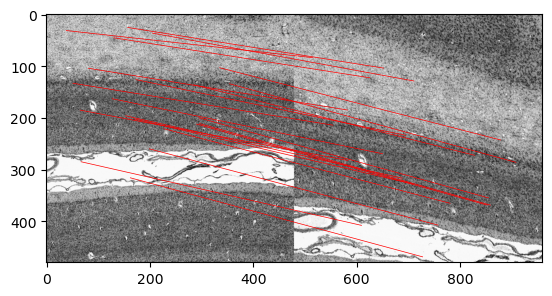

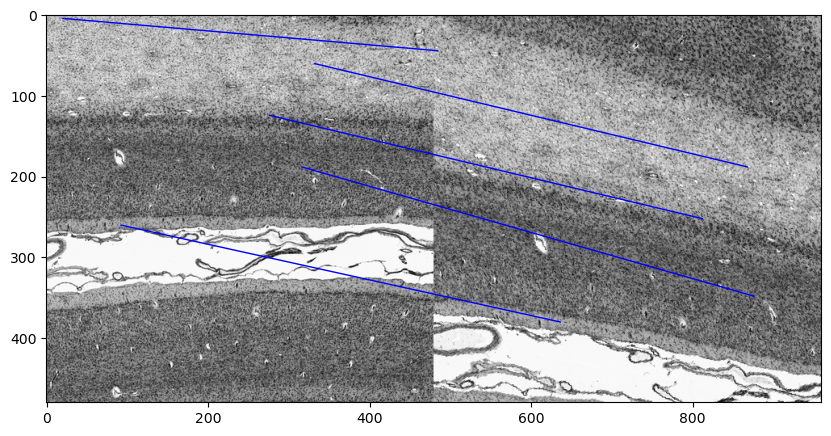

In [10]:
plot_images_with_matches_via_mapping(image_1=image_1_crop, image_2=image_2_crop, coordinate_mapping=crop_coordinate_mapping, number_of_matches=40, sample_keypoints_randomly=True)
plot_images_with_matches_via_match_matrix(image_1=image_1_crop, image_2=image_2_crop, ground_truth_match_matrix=match_matrix, line_frequency=400, patch_size=patch_size)

In [21]:
coarse_features_crop_1, fine_features_crop_1 = backbone(image_1_crop.unsqueeze(0))

x (Input Tensor): torch.Size([1, 1, 640, 640])
x0 (Initial Convolution Output): torch.Size([1, 64, 320, 320])
x1 (Layer 1 Output): torch.Size([1, 64, 320, 320])
x2 (Layer 2 Output): torch.Size([1, 96, 160, 160])
x3 (Layer 3 Output): torch.Size([1, 128, 80, 80])
x3_out (Layer 3 OutConv Output): torch.Size([1, 128, 80, 80])
x3_out_2x (Upsampled x3_out): torch.Size([1, 128, 160, 160])
x2_out (Layer 2 OutConv Output): torch.Size([1, 96, 160, 160])
x2_out_2x (Upsampled x2_out): torch.Size([1, 96, 160, 160])
x1_out (Layer 1 OutConv Output): torch.Size([1, 64, 320, 320])

Tensor Dimension Relationships:
x0: Output of the initial convolution, batch normalization, and ReLU applied to the input.
x1: Output of layer1, representing features at 1/2 of the input resolution.
x2: Output of layer2, downsampled to 1/4 of the input resolution.
x3: Output of layer3, further downsampled to 1/8 of the input resolution.
x3_out: Coarse features at 1/8 resolution, output of layer3_outconv.
x3_out_2x: Upsampled

In [22]:
coarse_features_crop_1.shape, fine_features_crop_1.shape

(torch.Size([1, 128, 80, 80]), torch.Size([1, 64, 320, 320]))

In [17]:
torch.Tensor([[0, 0, 1]]).unsqueeze(2).shape

torch.Size([1, 3, 1])

In [25]:
torch.column_stack([sample_random_affine_matrix(0.3), torch.Tensor([[0, 0, 1]]).unsqueeze(1)])

tensor([[[ 1.1474, -0.2228,  0.0000],
         [-0.2745,  0.7119,  0.0000],
         [ 0.0000,  0.0000,  1.0000]]])

# Projective transformation

In [1]:
import torch
def transform_grid_coordinates_perspective(
    grid_coordinates: torch.Tensor, transformation_matrix: torch.Tensor
) -> torch.Tensor:
    """
    Apply a transformation (affine or perspective) to a grid of image coordinates.

    This function transforms each coordinate in the provided grid according to the specified transformation matrix.
    It supports both affine (2x3) and perspective (3x3) transformation matrices.

    Args:
        grid_coordinates (torch.Tensor): A tensor of shape (height, width, 2) representing the grid of image coordinates.
        transformation_matrix (torch.Tensor): A 2x3 affine or 3x3 perspective transformation matrix.

    Returns:
        torch.Tensor: A tensor of the transformed grid coordinates, maintaining the original shape (height, width, 2).
    """
    original_shape = grid_coordinates.shape
    # Flatten the grid coordinates to shape (-1, 2) for easier matrix multiplication
    flat_grid_coordinates = grid_coordinates.view(-1, 2)

    # Create homogeneous coordinates by appending a ones column
    ones_column = torch.ones(flat_grid_coordinates.shape[0], 1, device=flat_grid_coordinates.device)
    homogeneous_coordinates = torch.cat([flat_grid_coordinates, ones_column], dim=1)

    # Check if the transformation matrix is affine (2x3) and convert it to a 3x3 matrix by appending [0, 0, 1]
    if transformation_matrix.shape == (2, 3):
        last_row = torch.tensor([[0, 0, 1]], device=transformation_matrix.device, dtype=transformation_matrix.dtype)
        transformation_matrix = torch.cat([transformation_matrix, last_row], dim=0)

    # Apply the transformation
    transformed_coordinates_homogeneous = torch.mm(homogeneous_coordinates, transformation_matrix.t())

    # Convert from homogeneous back to Cartesian coordinates
    transformed_coordinates = transformed_coordinates_homogeneous[:, :2] / transformed_coordinates_homogeneous[:, 2:3]

    # Reshape back to the original grid shape
    transformed_grid_coordinates = transformed_coordinates.view(original_shape)

    return transformed_grid_coordinates


In [74]:
import torch
from torch import nn
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, List
from source.data_processing.image_reading import read_image
from source.data_processing.keypoints import generate_image_grid_coordinates
from source.data_processing.transformations import (
    sample_random_affine_matrix,
    sample_random_perspective_matrix,
    transform_grid_coordinates,
    translate_fine_to_coarse,
    get_relative_coordinates,
)
from source.data_processing.cropping import (
    sample_crop_coordinates,
    crop_image,
    create_crop_coordinate_mapping,
)
from source.data_processing.patch_processing import (
    create_match_matrix,
    get_patch_coordinates,
)
from kornia.geometry.transform import warp_perspective
import os


def collate_fn(batch: List[Tuple]) -> Tuple[torch.Tensor]:
    """
    Custom collate function to handle batches of data with variable-sized relative coordinates.

    Args:
        batch: A list of tuples with the structure returned by `__getitem__` method of your dataset.

    Returns:
        A batch with the relative coordinates packed in a list and other data stacked as usual.
    """
    # Unzip the batch
    (
        image_1_crops,
        image_2_crops,
        match_matrices,
        relative_coordinates,
        crop_coordinate_mappings,
    ) = zip(*batch)

    # Stack tensors where possible
    image_1_crops = torch.stack(image_1_crops)
    image_2_crops = torch.stack(image_2_crops)
    match_matrices = torch.stack(match_matrices)
    crop_coordinate_mappings = torch.stack(crop_coordinate_mappings)
    relative_coordinates = torch.row_stack(relative_coordinates)

    # relative_coords is already a list of tensors of varying sizes; no need to stack

    return (
        image_1_crops,
        image_2_crops,
        match_matrices,
        relative_coordinates,
        crop_coordinate_mappings,
    )


class BrainDatasetProjective(Dataset):
    def __init__(
        self,
        images_directory: str,
        train: bool,
        transformation_threshold: float,
        crop_size: int,
        max_translation_shift: int,
        patch_size: int,
        fine_height_width: int,
        transform: transforms.transforms.Compose = None,
        return_crop_coordinates: bool = False,
    ) -> None:
        super().__init__()
        self.train = train
        self.image_names = self._get_image_names(images_directory=images_directory)
        self.images_directory = images_directory
        self.transform = transform
        self.transformation_threshold = transformation_threshold
        self.crop_size = crop_size
        self.max_translation_shift = max_translation_shift
        self.patch_size = patch_size
        self.fine_height_width = fine_height_width
        self.return_crop_coordinates = return_crop_coordinates

    def __len__(self) -> int:
        """
        Return the number of images in the dataset -1, since this dataset works with pairs of images.
        """
        return len(self.image_names[:-1])

    def _get_image_names(self, images_directory: str) -> List[str]:
        """
        Load image names from the directory based on training or testing phase.

        Args:
            images_directory (str): Directory path containing images.

        Returns:
            List[str]: A list of image file names.
        """
        image_files = os.listdir(images_directory)
        return image_files[:-2] if self.train else image_files[-2:]

    def _get_images(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Load a pair of images from the dataset.

        Args:
            index (int): Index of the pair of images.

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: A tuple containing the images.
        """
        image_1 = read_image(
            os.path.join(self.images_directory, self.image_names[index])
        )
        image_2 = read_image(
            os.path.join(self.images_directory, self.image_names[index + 1])
        )
        print(self.image_names[index], self.image_names[index + 1])

        image_1 = transforms.ToTensor()(image_1)
        image_2 = transforms.ToTensor()(image_2)

        return image_1, image_2

    def __getitem__(self, index: int):
        """
        Retrieves a transformed and preprocessed sample from the dataset at the specified index.

        This method performs several steps:
        1. Reads the original images (image_1 and image_2) corresponding to the given index.
        2. Applies transformations (e.g., normalization) to both images.
        3. Applies a random affine transformation to image_2.
        4. Generates and transforms a grid of pixel coordinates to map the correspondence between image_1 and the transformed image_2.
        5. Samples valid crop positions for both images and crops them.
        6. Generates a crop coordinate mapping to identify corresponding pixels between the two cropped images.
        7. Creates a binary match matrix indicating which patches in the two crops match.
        8. Determines the mid-pixels of matched patches and translates these points to the fine feature level.
        9. Computes the relative positions of the transformed mid-pixels of image_1_crop with respect to the mid-pixels of image_2_crop patches in the fine feature level.

        Args:
            index (int): The index of the sample to retrieve.

        Returns:
            tuple: A tuple containing the following elements:
                - image_1_crop (torch.Tensor): The cropped patch from image_1.
                - image_2_crop (torch.Tensor): The cropped and transformed patch from image_2.
                - match_matrix (torch.Tensor): A binary matrix indicating matches between patches in the two crops.
                - relative_coordinates (torch.Tensor): Relative coordinates of the transformed mid-pixels of image_1 with respect to image_2 at the fine feature level.
                - crop_coordinate_mapping (torch.Tensor): A mapping between the two crops.
        """
        # Read whole image
        image_1, image_2 = self._get_images(index=index)
        image_2_size = image_2.shape[-2:]

        # Apply transformations if passed (eg normlaization)
        if self.transform:
            image_1 = self.transform(image_1)
            image_2 = self.transform(image_2)

        # Apply random affine transformation to image 2
        transformation_matrix = sample_random_perspective_matrix(0.35, 0.0001)
        
        image_2_transformed = warp_perspective(
            src=image_2.unsqueeze(0),
            M=transformation_matrix,
            dsize=image_2_size,
            mode="nearest",
        )[0]

        # Generate (height, width, 2) grid of pixel coordinates for image 2
        grid_coordinates = generate_image_grid_coordinates(image_size=image_2_size)

        # Transform the grid coordinates according to the affine transformation
        # Pixel (i,j) of image_1 corresponds to pixel image_coordinate_mapping[i,j] in image_2
        image_coordinate_mapping = transform_grid_coordinates(
            grid_coordinates=grid_coordinates,
            transformation_matrix=transformation_matrix[0],
        )

        # Sample valid crop positions for image_1 and image_2_transformed
        crop_position_image_1, crop_position_image_2 = sample_crop_coordinates(
            coordinate_mapping=image_coordinate_mapping,
            crop_size=self.crop_size,
            max_translation_shift=self.max_translation_shift,
        )

        # Crop the images
        image_1_crop = crop_image(
            image=image_1, crop_position=crop_position_image_1, crop_size=self.crop_size
        )
        image_2_crop = crop_image(
            image=image_2_transformed,
            crop_position=crop_position_image_2,
            crop_size=self.crop_size,
        )

        # Generate a mapping between the two crops - interpreted similar to image_coordinate_mapping
        crop_coordinate_mapping = create_crop_coordinate_mapping(
            image_coordinate_mapping=image_coordinate_mapping,
            crop_position_image_1=crop_position_image_1,
            crop_position_image_2=crop_position_image_2,
            crop_size=self.crop_size,
        )

        # Final step of coarse supervision
        # Match matrix can be interpreted as a binary matrix indicating patch matches
        # match_matrix[i,j] = 1 if patch i in image_1_crop matches patch j in image_2_crop
        match_matrix = create_match_matrix(
            crop_coordinate_mapping=crop_coordinate_mapping,
            crop_size=self.crop_size,
            patch_size=self.patch_size,
        )

        # Beginning fine supvervison
        # Get matched patches in crop 1 and crop 2
        crop_1_patch_indices = match_matrix.nonzero()[
            :, 0
        ]  # Get all matched patches indices in crop 1
        crop_2_patch_indices = match_matrix.nonzero()[
            :, 1
        ]  # Get all matched patches indices in crop 2

        # Get mid point of patches in crop 1 and crop 2
        patch_size_half = self.patch_size // 2
        crop_1_patch_mid_indices = (
            get_patch_coordinates(patch_indices=crop_1_patch_indices, patch_size=self.patch_size, num_patches_per_side=self.crop_size // self.patch_size)
            + torch.Tensor([patch_size_half, patch_size_half]).long()
        )

        crop_2_patch_mid_indices = (
            get_patch_coordinates(patch_indices=crop_2_patch_indices, patch_size=self.patch_size, num_patches_per_side=self.crop_size // self.patch_size)
            + torch.Tensor([patch_size_half, patch_size_half]).long()
        )

        # Translate the mid points of patches in crop 2 to the fine feature level
        crop_2_patch_mid_indices_fine = translate_fine_to_coarse(
            fine_coordinates=crop_2_patch_mid_indices, coarse_size=self.fine_height_width, fine_size=self.crop_size
        )

        # Note: An element in crop_2_patch_mid_indices(_fine) doesnt necessarily correspond to the same pixel as the element in crop_1_patch_mid_indices(_fine)
        # It is just the mid point of the matched patch in the crop
        # Therefore we need to find the exact pixel in crop 2 that corresponds to crop_1_patch_mid_indices(_fine)

        # Compute where the mid point of crop 1 went exactly in crop 2 through the affine transformation.
        crop_1_mid_pixels_transformed = crop_coordinate_mapping[
            crop_1_patch_mid_indices[:, 1], crop_1_patch_mid_indices[:, 0]
        ]
        crop_1_mid_pixels_transformed_fine = translate_fine_to_coarse(
            crop_1_mid_pixels_transformed,
            coarse_size=self.fine_height_width,
            fine_size=self.crop_size,
        )

        # Computed the relative position of crop_1_mid_pixels_transformed_fine wrt crop_2_patch_mid_indices_fine
        # At test time we only know the mid point of patches in crop_2 (or in the fine feature level) but not
        # the exact pixel or relative coordinates. Therefore the model needs to predict the relative coordinates.
        # Relative coordinates are [-1, 1] for (top-left, bottom-right) corners of the patch.
        relative_coordinates = get_relative_coordinates(
            transformed_coordinates=crop_1_mid_pixels_transformed_fine,
            reference_coordinates=crop_2_patch_mid_indices_fine,
        )

        if self.return_crop_coordinates:
            return (
                image_1_crop,
                image_2_crop,
                match_matrix,
                relative_coordinates,
                crop_coordinate_mapping,
                crop_position_image_1,
                crop_position_image_2,
            )

        # Create the final output
        # Note: The output is a tuple of 5 elements
        return (
            image_1_crop,
            image_2_crop,
            match_matrix,
            relative_coordinates,
            crop_coordinate_mapping,
        )


In [75]:
crop_size = 480
transformation_threshold = 0.3
patch_size = 8
max_translation_shift = 50
fine_height_width = (crop_size//patch_size)*4
coarse_height_width = crop_size//patch_size
images_directory = "data/cyto_downscaled_3344_3904/"
use_train_data = True

dataset_train = BrainDatasetProjective(
    images_directory=images_directory,
    train=use_train_data,
    transformation_threshold=transformation_threshold,
    crop_size=crop_size,
    patch_size=patch_size,
    max_translation_shift=max_translation_shift,
    fine_height_width=fine_height_width,
    # transform=v2.Compose([v2.Normalize(mean=[0.594], std=[0.204])]),
)

In [88]:
sample = dataset_train[0]

B20_0429_Slice15_transformed.tif B20_0430_Slice15_transformed.tif


In [89]:
image_1_crop, image_2_crop, match_matrix, relative_coordinates, crop_coordinate_mapping = sample

In [90]:
from source.visualization.image_visualization import plot_images_with_matches_via_mapping, plot_images_with_matches_via_match_matrix
import matplotlib.pyplot as plt

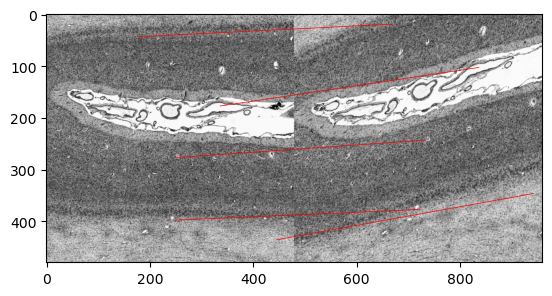

In [91]:
plot_images_with_matches_via_mapping(image_1=image_1_crop, image_2=image_2_crop, coordinate_mapping=crop_coordinate_mapping, number_of_matches=10, sample_keypoints_randomly=True)

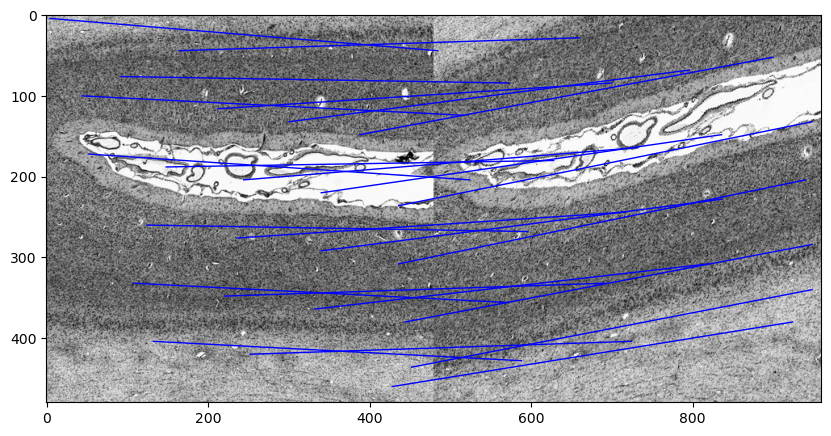

In [97]:
plot_images_with_matches_via_match_matrix(image_1=image_1_crop, image_2=image_2_crop, ground_truth_match_matrix=match_matrix, patch_size=8, line_frequency=120)

In [8]:
sample_random_affine_matrix(0.3)[:, :2]

tensor([[[ 1.2103, -0.1426,  0.0000],
         [-0.2808,  1.1378,  0.0000]]])

In [40]:
transformation_matrix = torch.Tensor([[1, 0.2, 0.01], [-0.3, 1, 0.01], [0, 0.0001, 1]])

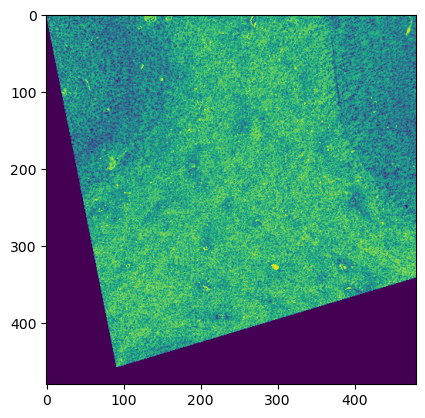

In [101]:
perspective_img = warp_perspective(src=image_1_crop.unsqueeze(0), M=transformation_matrix.unsqueeze(0), dsize=(480, 480), mode='nearest')
plt.imshow(perspective_img[0, 0])

In [49]:
import numpy as np
img = read_image("data/cyto_downscaled_3344_3904/B20_0429_Slice15_transformed.tif")
img = torch.Tensor(np.array(img))

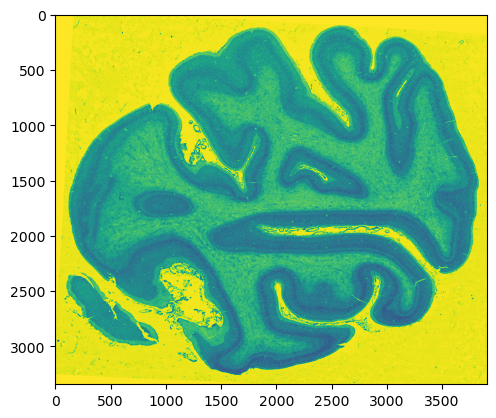

In [58]:
plt.imshow(img)

In [59]:
affine_matrix = sample_random_affine_matrix(0.3)

In [65]:
transformation_matrix[:, :2]

tensor([[[ 1.0076, -0.0560,  0.0000],
         [-0.0164,  1.0477,  0.0000]]])

In [68]:
from kornia.geometry.transform import warp_affine

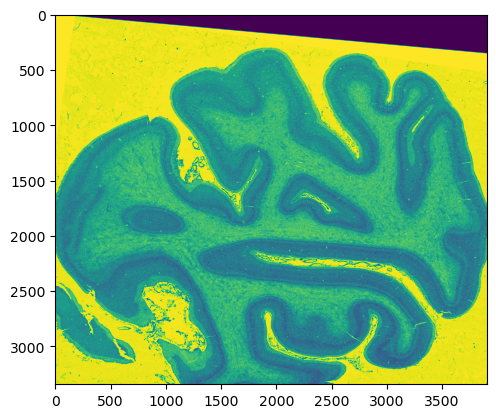

In [69]:
transformation_matrix = sample_random_affine_matrix(0.1)
perspective_img = warp_affine(src=img.unsqueeze(0).unsqueeze(0), M=transformation_matrix[:, :2], dsize=img.shape, mode='nearest')
plt.imshow(perspective_img[0, 0])
plt.show()

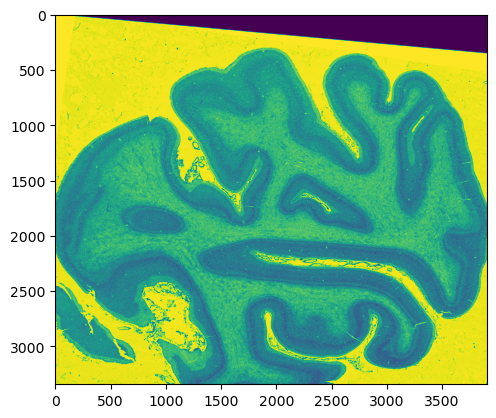

In [70]:
perspective_img = warp_perspective(src=img.unsqueeze(0).unsqueeze(0), M=transformation_matrix, dsize=img.shape, mode='nearest')
plt.imshow(perspective_img[0, 0])
plt.show()